# 🧪 Custom Linear Regression

In this notebook, we implement linear regression **from scratch** using Stochastic Gradient Descent. We then compare the performance of these implementations with **scikit-learn**'s `LinearRegression` model.

### ⚙️ Importing Libraries & Environment Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.typing import NDArray
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

pd.set_option("display.width", 150)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)

### 🧰 Utility Functions

In [3]:
def evaluate_regression_models(
    predictions: dict[str, NDArray[np.float64]], y: NDArray[np.float64]
) -> pd.DataFrame:
    """Evaluate multiple regression model predictions on the given dataset.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary where keys are
            model names and values are predicted target arrays corresponding to X.
        y (NDArray[np.float64]): True target values of shape (n_samples,).

    Returns:
        pd.DataFrame: DataFrame with evaluation metrics (MAE, MSE, R2) for each model.
            Rows correspond to model names; columns correspond to metrics.
    """
    evaluations = pd.DataFrame(columns=["MAE", "MSE", "R2"], index=predictions.keys())

    for name, y_pred in predictions.items():
        mae = mean_absolute_error(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        evaluations.loc[name] = [mae, mse, r2]

    return evaluations.astype(float)

In [4]:
def plot_regression_models(
    predictions: dict[str, NDArray[np.float64]],
    X: NDArray[np.float64],
    y: NDArray[np.float64],
    X_test: NDArray[np.float64],
) -> None:
    """Plot regression results for multiple models on scatter data.

    Args:
        predictions (dict[str, NDArray[np.float64]]): Dictionary mapping model names
            to predicted values for X_test.
        X (NDArray[np.float64]): Original feature data of shape (n_samples, 1)
            for scatter plot.
        y (NDArray[np.float64]): True target values corresponding to X.
        X_test (NDArray[np.float64]): Feature values where predictions are
            evaluated and plotted.
    """
    sns.scatterplot(x=X.flatten(), y=y.flatten(), alpha=0.3, label="Noisy data points")

    palette = sns.color_palette("Set1")
    for index, (name, y_pred) in enumerate(predictions.items()):
        plt.plot(
            X_test, y_pred, alpha=0.6, color=palette[index], linewidth=2, label=name
        )

    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()
    plt.show()

### 📥 Loading the Dataset

In [5]:
# Generate dataset
X, y = make_regression(
    n_samples=100, n_features=1, noise=10, bias=37.0, random_state=42
)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 🧠 Implementing Custom Model Algorithms

In [7]:
class MyLinearRegression:
    """Linear Regression using SGD with L1 and L2 regularization.

    This implementation performs optimization using batch size 1 (pure SGD)
    and supports both L1 (Lasso) and L2 (Ridge) regularization to reduce overfitting
    and encourage sparsity.

    Attributes:
        max_epochs (int): Maximum number of training iterations.
        learning_rate (float): Step size for parameter updates.
        tolerance (float): Threshold to determine convergence based on loss change.
        lambda_l1 (float): Coefficient for L1 regularization (Lasso).
        lambda_l2 (float): Coefficient for L2 regularization (Ridge).
        coef_ (NDArray[np.float64] | None): Learned weights for the linear model.
        intercept_ (float): Learned intercept (bias) term.
    """

    def __init__(
        self,
        max_epochs: int = 10000,
        learning_rate: float = 1e-4,
        tolerance: float = 1e-7,
        lambda_l1: float = 0,
        lambda_l2: float = 0,
        random_state: int | None = None,
    ):
        """Initialize the MyLinearRegression model.

        Args:
            max_epochs (int): Number of epochs for SGD. Default is 10,000.
            learning_rate (float): Step size for weight updates. Default is 1e-4.
            tolerance (float): Early stopping threshold for change in loss.
                Default is 1e-7.
            lambda_l1 (float): L1 regularization strength (sparsity). Default is 0.
            lambda_l2 (float): L2 regularization strength (weight decay). Default is 0.
            random_state (int | None): Seed for reproducible training. Default is None.
        """
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2
        self.rng = np.random.default_rng(random_state)

        self.coef_: NDArray[np.float64] | None = None
        self.intercept_: float = 0.0

    def _mse(self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
        """Compute mean squared error between true and predicted values.

        Args:
            y_true (NDArray[np.float64]): True target values.
            y_pred (NDArray[np.float64]): Predicted values.

        Returns:
            float: Mean squared error.
        """
        return np.mean((y_pred - y_true) ** 2)

    def _compute_gradients(
        self, x_i: NDArray[np.float64], y_i: float
    ) -> tuple[NDArray[np.float64], float]:
        """Compute gradients of the loss function with respect to weights and bias.

        Args:
            x_i (NDArray[np.float64]): Single input sample of shape (n_features,).
            y_i (float): True target value for the input sample.

        Returns:
            Tuple containing:
                - grad_coef (NDArray[np.float64]): Gradient w.r.t. coefficients.
                - grad_intercept (float): Gradient w.r.t. intercept.
        """
        y_i_pred = self.predict(x_i)
        error_i = y_i_pred - y_i

        grad_coef = x_i * error_i
        if self.lambda_l1 > 0:
            grad_coef += self.lambda_l1 * np.sign(self.coef_)
        if self.lambda_l2 > 0:
            grad_coef += self.lambda_l2 * self.coef_

        grad_intercept = error_i

        return grad_coef, grad_intercept

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Fit the linear regression model to training data using SGD.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).
            y (NDArray[np.float64]): Target vector of shape (n_samples,).
        """
        m, n_features = X.shape
        self.coef_ = np.zeros(n_features)

        prev_loss = float("inf")

        for _ in range(self.max_epochs):
            indices = self.rng.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for x_i, y_i in zip(X_shuffled, y_shuffled, strict=False):
                grad_coef, grad_intercept = self._compute_gradients(x_i, y_i)
                self.coef_ -= self.learning_rate * grad_coef
                self.intercept_ -= self.learning_rate * grad_intercept

            y_pred = self.predict(X)
            loss = self._mse(y, y_pred)
            loss += self.lambda_l2 * np.sum(self.coef_**2)
            loss += self.lambda_l1 * np.sum(np.abs(self.coef_))

            if abs(prev_loss - loss) < self.tolerance:
                break

            prev_loss = loss

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict target values using the trained model.

        Args:
            X (NDArray[np.float64]): Feature matrix of shape (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted values of shape (n_samples,).

        Raises:
            ValueError: If model has not been trained yet.
        """
        if self.coef_ is None:
            raise ValueError("Model is not trained yet. Call `fit` first.")
        return X @ self.coef_ + self.intercept_

### 🏋️‍♂️ Model Training

In [8]:
# Scikit-learn linear regression model
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# My SGD linear regression model
my_model = MyLinearRegression(lambda_l1=1e-3, lambda_l2=1e-3, random_state=42)
my_model.fit(X_train, y_train)

### 📊 Comparing Algorithm Versions

In [9]:
predictions = {
    "scikit-learn": sklearn_model.predict(X_test),
    "my": my_model.predict(X_test),
}

In [10]:
pd.DataFrame(
    data={
        "Coefficients": [sklearn_model.coef_, sklearn_model.coef_],
        "Intercepts": [my_model.intercept_, my_model.intercept_],
    },
    index=["scikit-learn", "my"],
)

,Coefficients,Intercepts
scikit-learn,[44.244182155974194],37.089619
my,[44.244182155974194],37.089619


In [11]:
evaluate_regression_models(predictions, y_test)

,MAE,MSE,R2
scikit-learn,8.416660,104.202227,0.937415
my,8.420751,104.334542,0.937336


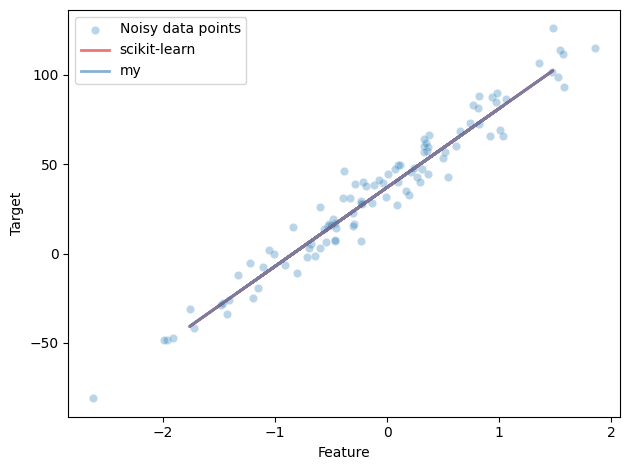

In [12]:
plot_regression_models(predictions, X, y, X_test)